In [33]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D,Conv1D, MaxPooling2D, MaxPooling1D, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.models import Model
import pathlib
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import datetime
import pandas as pd

In [3]:
# Directory Management for Raw Image datasets
data_dir_raw_image = 'datasets/image'
data_dir_raw_image = pathlib.Path(data_dir_raw_image)
raw_durian_images_dict = {
    'ripe' : list(data_dir_raw_image.glob('ripe/*')),
    'unripe' : list(data_dir_raw_image.glob('unripe/*')),
} 
raw_durian_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}
print(f'jumlah durian matang : {len(raw_durian_images_dict["ripe"])}')
print(f'jumlah durian mentah : {len(raw_durian_images_dict["unripe"])}')

jumlah durian matang : 50
jumlah durian mentah : 50


In [4]:
def load_data(data_dir):
    data_gas = []
    label_gas = []
    for label, class_name in enumerate(['ripe', 'unripe']):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.csv'):
                file_path = os.path.join(class_dir, filename)
                csv_data = pd.read_csv(file_path).values.flatten()
                data_gas.append(csv_data)
                label_gas.append(label)
    return np.array(data_gas), np.array(label_gas)

In [5]:
data_dir = 'datasets/aroma'
data_gas, label_gas = load_data(data_dir)
# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data_gas)
# Menyimpan scaler ke file
scaler_file = "scaler.pkl"
joblib.dump(scaler, scaler_file)
max_len = max(map(len, data))
data = np.array([np.pad(d, (0, max_len - len(d)), 'constant') for d in data])
len(data)
len(label_gas)

100

In [7]:
X_image, y_image = [], []
for durian_ripeness, images in raw_durian_images_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(200,200))
        X_image.append(resized_img)
        y_image.append(raw_durian_labels_dict[durian_ripeness])
X_image = np.array(X_image)
y_image = np.array(y_image)
len(y_image)

100

In [25]:
# Train Validation Test Split for Image CNN
X_train_val_image, X_test_image, y_train_val_image, y_test_image = train_test_split(X_image, y_image, train_size=0.8, random_state=42)
X_train_image, X_val_image, y_train_image, y_val_image = train_test_split(X_train_val_image, y_train_val_image, test_size=0.25, random_state=42)

In [26]:
# Train Validation Test Split for Gas CNN
X_train_val_gas, X_test_gas, y_train_val_gas, y_test_gas = train_test_split(data, label_gas, train_size=0.8, random_state=42)
X_train_gas, X_val_gas, y_train_gas, y_val_gas = train_test_split(X_train_val_gas, y_train_val_gas, test_size=0.25, random_state=42)

In [27]:
# Rescale for Image CNN
X_train_image = X_train_image / 255.0
X_val_image = X_val_image / 255.0
X_test_image = X_test_image / 255.0

In [12]:
convDim = 3  # Define the convolution dimension
input_shape_image = (200, 200, 3)  
input_shape_gas = (30, 1)  

# Define two separate input layers
input_image = Input(shape=input_shape_image)
input_gas = Input(shape=input_shape_gas)

In [29]:
# Convolution layer for image dataset
conv1_image = Conv2D(32, (convDim, convDim), activation='relu', input_shape=input_shape_image)(input_image)
pool1_image = MaxPooling2D(2, 2)(conv1_image)

conv2_image = Conv2D(64, (convDim, convDim), activation='relu')(pool1_image)
pool2_image = MaxPooling2D(2, 2)(conv2_image)

conv3_image = Conv2D(64, (convDim, convDim), activation='relu')(pool2_image)
pool3_image = MaxPooling2D(2, 2)(conv3_image)

conv4_image = Conv2D(64, (convDim, convDim), activation='relu')(pool3_image)
pool4_image = MaxPooling2D(2, 2)(conv4_image)

conv5_image = Conv2D(64, (convDim, convDim), activation='relu')(pool4_image)
pool5_image = MaxPooling2D(2, 2)(conv5_image)

conv6_image = Conv2D(64, (convDim, convDim), activation='relu')(pool5_image)
pool6_image = MaxPooling2D(2, 2)(conv6_image)

flat_image = Flatten()(pool6_image)

In [34]:
# Convolution layer for Gas dataset
conv_dim_gas = 3
conv1_gas = Conv1D(64, kernel_size=conv_dim_gas, activation='relu', input_shape=input_shape_gas)(input_gas)
conv2_gas = Conv1D(64, kernel_size=conv_dim_gas, activation='relu')(conv1_gas)
pool2_gas = MaxPooling1D(2, 2)(conv2_gas)

flat_gas = Flatten()(pool2_gas)

In [35]:
# Concatenate the flattened outputs
merged = concatenate([flat_image, flat_gas])

In [42]:
# Fully Connected Layer
fc2 = Dense(128, activation='relu')(merged)
fc3 = Dense(64, activation='relu')(fc2)
output = Dense(1, activation='sigmoid')(fc3)

# Create the model
model = Model(inputs=[input_image, input_gas], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 198, 198, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 97, 97, 64)           18496     ['max_pooling2d[0][0]'] 

In [43]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check the loss
    if(logs.get('accuracy') == 1.0):

      # Stop if threshold is met
      print("\nAccuracy is reached than 1.0 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()
# callbacks=callbacks

In [44]:
# Train the model
model_fit = model.fit(
 ( X_train_image, X_train_gas), 
 y_train_image, 
 epochs=50,
 validation_data=(
        ( X_val_image, X_val_gas), 
        ( y_val_image, y_val_gas)
    ),
#  callbacks=callbacks
 )

Epoch 1/50
2/2 [==============================] - 11s 5s/step - loss: 0.6850 - accuracy: 0.4500 - val_loss: 0.6612 - val_accuracy: 0.7000
Epoch 2/50
2/2 [==============================] - 4s 2s/step - loss: 0.6323 - accuracy: 0.7667 - val_loss: 0.6212 - val_accuracy: 0.7000
Epoch 3/50
2/2 [==============================] - 4s 2s/step - loss: 0.5815 - accuracy: 0.7167 - val_loss: 0.5500 - val_accuracy: 0.8000
Epoch 4/50
2/2 [==============================] - 4s 2s/step - loss: 0.5458 - accuracy: 0.8333 - val_loss: 0.4948 - val_accuracy: 0.8500
Epoch 5/50
2/2 [==============================] - 4s 2s/step - loss: 0.4623 - accuracy: 0.8167 - val_loss: 0.5098 - val_accuracy: 0.7000
Epoch 6/50
2/2 [==============================] - 4s 2s/step - loss: 0.4467 - accuracy: 0.7500 - val_loss: 0.4311 - val_accuracy: 0.8000
Epoch 7/50
2/2 [==============================] - 4s 2s/step - loss: 0.5053 - accuracy: 0.7833 - val_loss: 0.3976 - val_accuracy: 0.8000
Epoch 8/50
2/2 [========================

In [45]:
loss, accuracy = model.evaluate([X_test_image, X_test_gas], [y_test_image, y_test_gas])
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 0s 171ms/step - loss: 0.1166 - accuracy: 0.9000
Test Loss: 0.11656630039215088
Test Accuracy: 0.8999999761581421


In [48]:
predictions = model.predict([X_test_image, X_test_gas])
predictions = np.round(predictions,2)
predictions

1/1 [==============================] - 0s 357ms/step


array([[1.  ],
       [1.  ],
       [1.  ],
       [0.  ],
       [0.  ],
       [0.01],
       [0.  ],
       [1.  ],
       [0.02],
       [0.  ],
       [0.  ],
       [0.78],
       [1.  ],
       [0.01],
       [1.  ],
       [0.  ],
       [1.  ],
       [1.  ],
       [0.  ],
       [0.53]], dtype=float32)

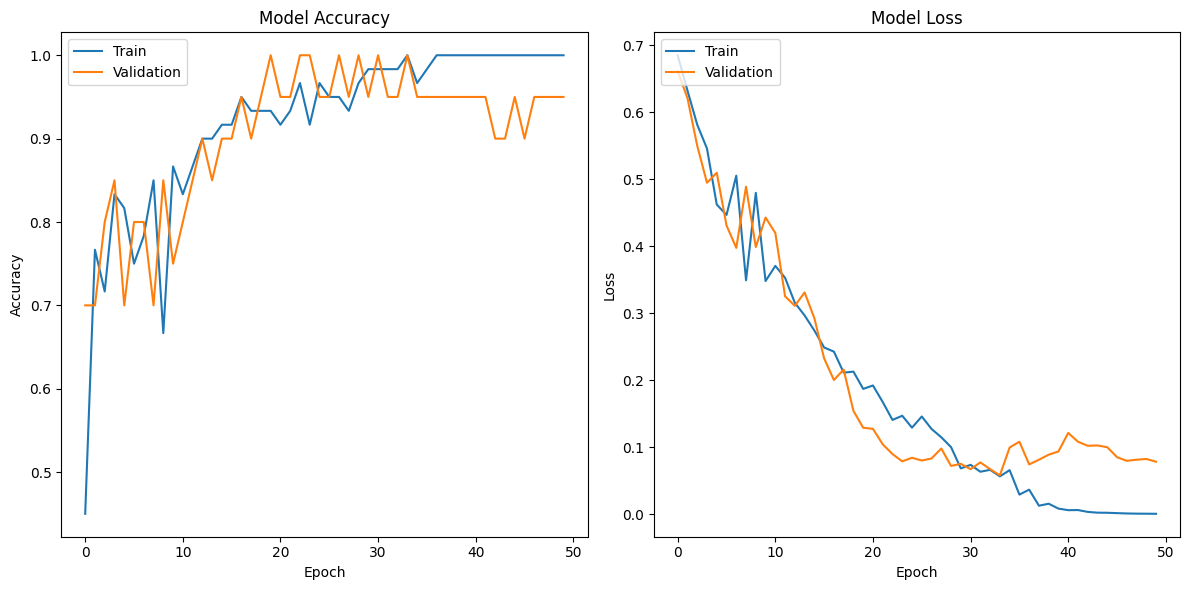

In [49]:
# Plot training and validation history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])  # Add validation accuracy
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])  # Add validation loss
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
# Get current date and time
now = datetime.datetime.now()

# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%d%m%Y-%H%M")

# Save the plot with the specified name format
plt.savefig(f"{date_time_str}.png")

plt.show()

1/1 [==============================] - 0s 202ms/step


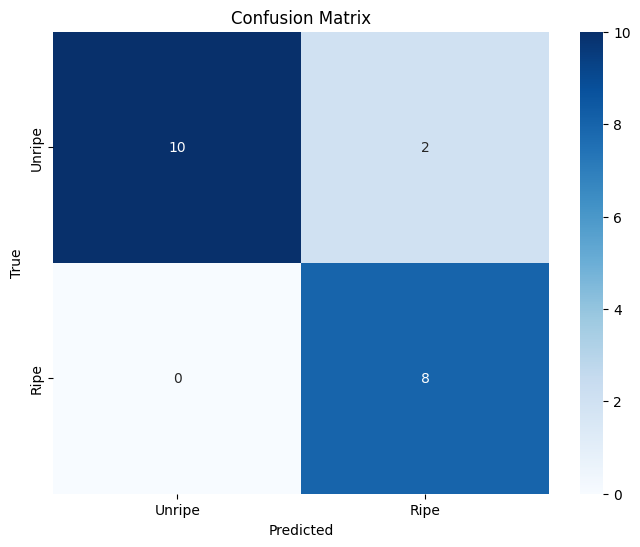

In [50]:
# Generate predictions on the test set
y_pred = model.predict([X_test_image, X_test_gas])
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming it's a binary classification problem

# Assuming y_test contains the true labels for the test set
# Generate the confusion matrix
conf_mat = confusion_matrix(y_test_image, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open(f'{date_time_str}.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\fzrah\AppData\Local\Temp\tmplnyif19o\assets


INFO:tensorflow:Assets written to: C:\Users\fzrah\AppData\Local\Temp\tmplnyif19o\assets
